In [46]:
import numpy as np
import matplotlib.pyplot as plt
from helpers.descriptors import Section
from os import listdir
from yaml import load
from yaml.loader import Loader
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import os 

from tqdm import tqdm

from helpers.utils import reorder_points

In [47]:
font = {'family' : 'DejaVu Sans',
        'sans-serif': "Arial",
        'weight' : 'normal',
        'size'   : 18}

mpl.rc('font', **font)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 10

In [66]:
BASENAME = "02_GrotteDeLaCascadeDeMotiers"
PASSAGE = "LaCave"
SECTION = "1"

PROCESSING_PARAMS = f"../../real_data/{BASENAME}/params.yaml"
SECTIONS_FILEPATH = f"../../real_data/{BASENAME}/process/sections_as_polylines/"
PROCESSING_FILEPATH = f"../../real_data/{BASENAME}/process/planes_as_vectors"
params = load(open(PROCESSING_PARAMS), Loader)

GLOBAL_SHIFT = params["alignment"]["globalShift"]

In [67]:
sections = []
sections_fp =[section_fp for section_fp in listdir(SECTIONS_FILEPATH) if f"{PASSAGE}_{SECTION}_reordered" in section_fp]
section_idx = [int(section_fp.strip(".txt").split("_")[-1]) for section_fp in sections_fp]

In [68]:
sections_count = len(sections_fp)

print(sections_count)

104


In [69]:
# read in the filepaths
for section in sections_fp:
    full_fp = os.path.normpath(os.path.join(SECTIONS_FILEPATH, section))
    data = np.loadtxt(full_fp)
    sections.append(data)

In [70]:
# curvilinear coordinates
planes_origin = np.loadtxt(f"../../real_data/{BASENAME}/process/planes_as_vectors/{PASSAGE}_{SECTION}_Planes_Origin.txt")
curvilinear_pos = np.cumsum(np.linalg.norm(np.diff(planes_origin, axis = 0), axis = 1))
curvilinear_pos = np.pad(curvilinear_pos, (1, 0), "constant", constant_values = (0, 0))

In [71]:
ordered = []
verbose = False
for data, curvilinear_idx in tqdm(zip(sections[:], section_idx), total = len(sections)):
    
    dists = np.linalg.norm(np.diff(data, axis = 0), axis = 1)
    id0 = 0
    idx = -1
    
    if np.any(dists > 1):
        if verbose == True:
            print("likely several segments")
        split = np.argwhere(dists > 0.2).flatten()
        split_data = np.array(np.split(data, split), dtype =object)
        ind = np.argmax(np.array([len(seg) for seg in split_data]))
    
        data = split_data[ind]

    # recentre to barycentre
    data = data - np.mean(data, axis = 0)
    # check if closed: 
    closure = np.linalg.norm(data[-1] - data[0])
    if closure > 0.2:
        #print("there may be a closure error")
        s = Section(data, "ClosureError", curvilinear_pos[curvilinear_idx], from3d=False)
    else: 
        s = Section(data, "all ok", curvilinear_pos[curvilinear_idx], from3d=False)
    ordered.append(s)


100%|█████████████████████████████████████████████████████████████████████████████| 104/104 [00:00<00:00, 13863.26it/s]


In [72]:
for section in tqdm(ordered, total= len(ordered)):
    section.compute_descriptors()
    section.fitEllipse()

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:24<00:00,  4.29it/s]


In [73]:
def plotDescriptor(ordered, descriptor, ax, ax_hist, ax_inset1, ax_inset2, start= 0, stop= None, inset_size = 10):
    ok_sections, xi_ok, descriptor_ok = np.array([(n,section.curvilinear_pos, section.__dict__[descriptor]) for n,section in enumerate(ordered) if section.flag != "ClosureError"][start:stop]).T
    bad_sections,  xi_bad, descriptor_bad = np.array([(n,section.curvilinear_pos, section.__dict__[descriptor]) for n,section in enumerate(ordered) if section.flag == "ClosureError"][start:stop]).T

    # coordinates for plotting in the insets
    ok_sections2d = [section.points2d for section in ordered if section.flag != "ClosureError"][start:stop]
    bad_sections2d = [section.points2d for section in ordered if section.flag == "ClosureError"][start:stop]

    # indices to integers. 
    ok_sections = ok_sections.astype(int)
    bad_sections = bad_sections.astype(int)

    # indices of max and min descriptor value 
    argmax_descriptor = np.argmax(descriptor_ok)
    argmin_descriptor = np.argmin(descriptor_ok)

    _min = min(descriptor_ok)
    _max = max(descriptor_ok)
    _range = _max - _min
    
    # Plotting along the curviline
    ax.plot(xi_ok, descriptor_ok, "-o", markersize = 4)
    ax.scatter(curvilinear_pos[ok_sections][argmax_descriptor], descriptor_ok[argmax_descriptor], color = "white",  edgecolor = "firebrick", zorder = 100, s = 50, marker = "D")
    ax.scatter(curvilinear_pos[ok_sections][argmin_descriptor], descriptor_ok[argmin_descriptor], color = "white", edgecolor = "dodgerblue", zorder = 100, s = 50, marker = "D")
    ax.plot(xi_bad, descriptor_bad, "o", markersize = 4)
    ax.set_ylim(_min -0.1*_range, _max +0.1*_range)
    # Plotting the histogram
    ax_hist.hist(descriptor_ok, density = True, orientation = "horizontal", bins = 20)

    # Plotting the insets
    ax_inset1.plot(ok_sections2d[argmax_descriptor][:,0], ok_sections2d[argmax_descriptor][:,1], color = "firebrick")
    ax_inset2.plot(ok_sections2d[argmin_descriptor][:,0], ok_sections2d[argmin_descriptor][:,1])

    # if hydraulic diameter. 
    if (descriptor == "hydraulic_diameter") or (descriptor == "circularity"): 
        plotDH(ordered, ok_sections, argmax_descriptor, ax_inset1)
        plotDH(ordered, ok_sections, argmin_descriptor, ax_inset2)
        
    elif descriptor == "solidity":
        plotCHull(ordered, ok_sections, argmax_descriptor, ax_inset1)
        plotCHull(ordered, ok_sections, argmin_descriptor, ax_inset2)
    elif descriptor == "mean_dist_to_ellipse_scaled":
        plotEllipse(ordered, ok_sections, argmax_descriptor, ax_inset1)
        plotEllipse(ordered, ok_sections, argmin_descriptor, ax_inset2)

    # make cosmetic ajustments to insets 
    for ax_inset in (ax_inset1, ax_inset2):
        ax_inset.set_aspect("equal")
        ax_inset.tick_params(top=True, right=True, left = False, bottom= False)
        ax_inset.xaxis.tick_top()
        ax_inset.yaxis.tick_right()
        ax_inset.yaxis.set_label_position("right")
        ax_inset.set_ylabel("z [m]")
        ax_inset.set_xlim(-inset_size, inset_size)
        ax_inset.set_ylim(-inset_size, inset_size)


        tick_pos = np.round(inset_size*2 /3)
        ax_inset.set_xticks([-tick_pos,0,tick_pos])
        ax_inset.set_yticks([-tick_pos,0,tick_pos])
    
    ax.grid(lw = 0.5, ls="--")

    for spine in ["top","right"]:
        ax.spines[spine].set_visible(False)
        ax_hist.spines[spine].set_visible(False)

    # annotate with some interesting trivia

    print("mean {}: {:.3f}".format(descriptor, np.mean(descriptor_ok)))
    print("std {}: {:.4f}".format(descriptor, np.std(descriptor_ok)))

In [74]:
def plotDH(ordered, ok_sections, indx, ax):
    dh = ordered[ok_sections[indx]].hydraulic_diameter
    xi = np.linspace(0, 2*np.pi, 100)
    # upper semi-circle
    ax.fill_between(1/2*dh*np.cos(xi) , 0 , 1/2*dh*np.sin(xi)  , alpha = 0.66, color = "grey", edgecolor=None)
    return ax
    

In [75]:
def plotCHull(ordered, ok_sections, indx, ax):
    chull = ordered[ok_sections[indx]].convexhull
    chull_wrapped = np.zeros((len(chull)+1, 2))
    chull_wrapped[:-1] = chull
    chull_wrapped[-1] = chull[0]
    
    ax.plot(chull_wrapped[:,0], chull_wrapped[:, 1], zorder = -10, color = "C1")
    return ax

In [76]:
def plotEllipse(ordered, ok_sections, indx, ax):
    ellipse = ordered[ok_sections[indx]].fitted_ellipse

    ax.plot(ellipse[:,0], ellipse[:, 1], zorder = -10, color = "C1")
    return ax

0
mean area: 3.355
std area: 1.5102
7
mean hydraulic_diameter: 1.338
std hydraulic_diameter: 0.2196
14
mean solidity: 0.780
std solidity: 0.1180
21
mean mean_dist_to_ellipse_scaled: 0.259
std mean_dist_to_ellipse_scaled: 0.1508
28
mean circularity: 0.468
std circularity: 0.1557


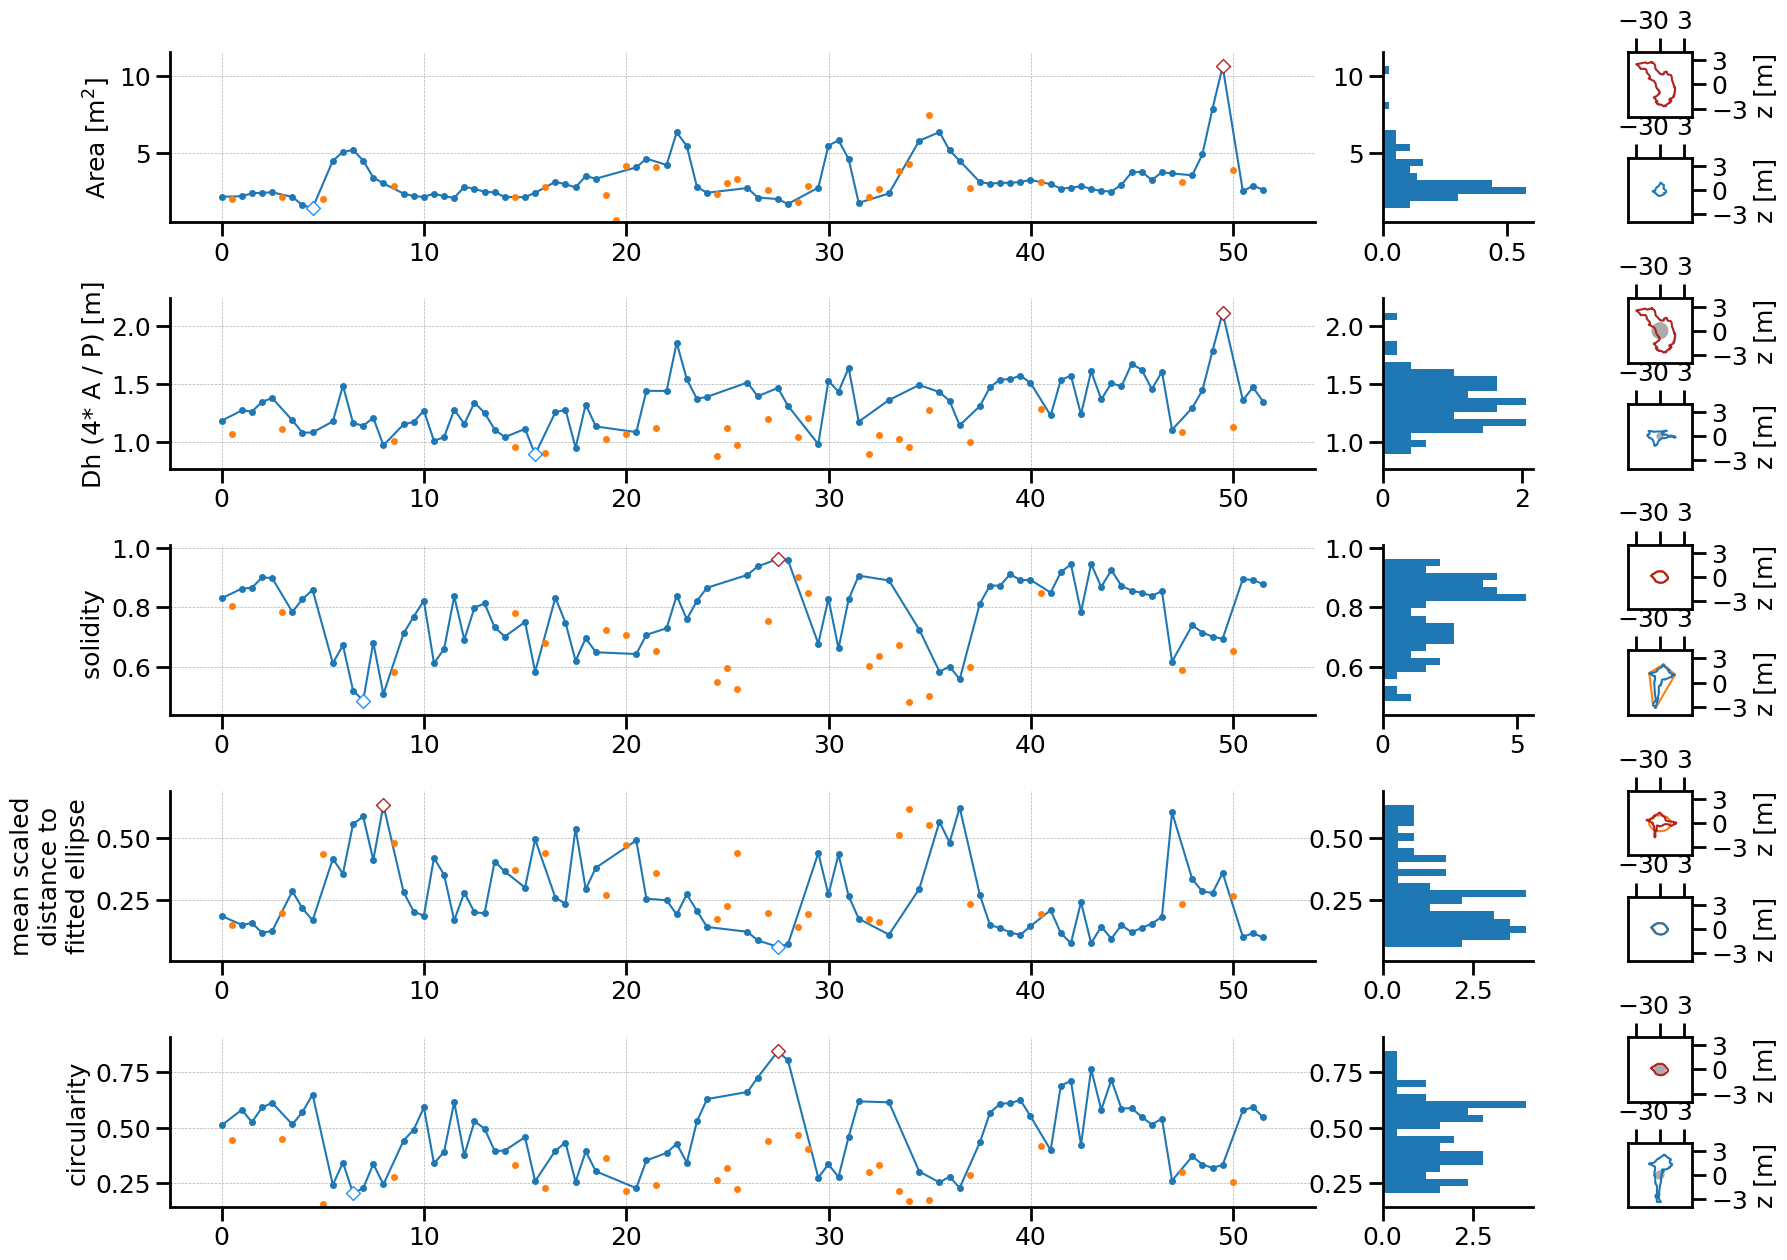

In [78]:
fig = plt.figure(figsize = (20, 15))
gs = GridSpec(33, 50)
labels = ["Area [m$^2$]", "Dh (4* A / P) [m]", "solidity ", "mean scaled\ndistance to\nfitted ellipse", "circularity"]
attributes = ["area", "hydraulic_diameter", "solidity", "mean_dist_to_ellipse_scaled", "circularity"]

for n, (descriptor, label) in enumerate(zip(attributes, labels)):
    i = 7*n
    print(i)
    ax = fig.add_subplot(gs[i:i+5, :37])
    ax.set_ylabel(label)
    
    ax_hist = fig.add_subplot(gs[i:i+5, 39:44], sharey = ax)
    
    ax_inset1 = fig.add_subplot(gs[i:i+2, 46:])
    ax_inset2 = fig.add_subplot(gs[i+3:i+5, 46:], sharex = ax_inset1, sharey = ax_inset1)
    
    plotDescriptor(ordered, descriptor, ax, ax_hist, ax_inset1, ax_inset2, start= 0, stop= None, inset_size=4)
    
plt.savefig(os.path.join(PROCESSING_FILEPATH, f"{BASENAME}_{PASSAGE}_{SECTION}_stats.pdf"))

In [ ]:
fig, ax = plt.subplots()

ax.plot(ordered[9].points2d[:,0], ordered[9].points2d[:,1])
barycentre = ordered[9].barycentre
dh = ordered[9].hydraulic_diameter
ax.scatter(barycentre[0], barycentre[1])
xi = np.linspace(0, 2*np.pi, 100)
    # upper semi-circle
ax.fill_between(1/2*dh*np.cos(xi) + barycentre[0], 0 , 1/2*dh*np.sin(xi)  + barycentre[1], alpha = 0.66, color = "grey", edgecolor=None)



In [ ]:
origins = np.loadtxt(os.path.join(PROCESSING_FILEPATH, f"{PASSAGE}_{SECTION}_Planes_Origin.txt"))
vectors = np.loadtxt(os.path.join(PROCESSING_FILEPATH, f"{PASSAGE}_{SECTION}_Planes.txt"))

In [ ]:
plt.plot(origins[:, 0], origins[:, 1])

xy_norm = np.linalg.norm(vectors[:, [0,1]], axis = 1)
vectors_xy = vectors[:, [0,1]] / np.expand_dims(xy_norm, -1)
plt.quiver(origins[::, 0], origins[::, 1], vectors_xy[:-1, 1], -vectors_xy[:-1, 0], headwidth = 1, width = 0.0025)
plt.quiver(origins[::, 0], origins[::, 1], -vectors_xy[:-1, 1], vectors_xy[:-1, 0], headwidth = 1, width = 0.0025)



In [ ]:
fig, ax = plt.subplots(figsize = (30, 12))

ax.plot(origins[:, 0], origins[:, 2])

xz_norm = np.linalg.norm(vectors[:, [0,2]], axis = 1)
vectors_xz = vectors[:, [0,2]] / np.expand_dims(xz_norm, -1)
ax.quiver(origins[::, 0], origins[::, 2], vectors_xz[:-1, 1], -vectors_xz[:-1, 0], headwidth = 1, width = 0.0025)
ax.quiver(origins[::, 0], origins[::, 2], -vectors_xz[:-1, 1], vectors_xz[:-1, 0], headwidth = 1, width = 0.0025)
ax.set_aspect("equal")

plt.show()

In [ ]:
fig, axes = plt.subplots(10, 10, figsize= (32, 32))

for section, ax in zip(ordered[start:stop:4], axes.flatten()):
    if section.flag == "ClosureError":
        ax.plot(section.points2d[:,0], section.points2d[:,1], color = "firebrick")
    else: 
        ax.plot(section.points2d[:,0], section.points2d[:,1], color = "dodgerblue")

    ax.set_aspect(aspect="equal")
    ax.set_xlim(-15,15)
    ax.set_ylim(-6, 6)
